In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, z_score_normalization
from project.utils import collate_fn, plot_mri_slice, plot_all_slices, plot_all_slices_from_array, collatev2
import winsound
from torchvision.models import resnet18, ResNet18_Weights
from project.utils import memcheck

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.18 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
import logging
logger = logging.getLogger('andy')
fh = logging.FileHandler('andy.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 3)

In [4]:
ch1 = ds.load_raw_mri(1)
data = data[data.mri.isin(ch1)]
data.shape

(385, 3)

In [5]:
transform = NiftiToTensorTransform(target_shape = (300, 300), rpn_mode=False) # Hanggang dito lang kaya ng GPU mem ko

cases = data.mri
masks = data.masks
target = data.target

In [6]:
dataset = VALDODataset(
    cases=cases,
    masks=masks,
    target=target,
    transform=transform,
    normalization=z_score_normalization,
)

In [7]:
dloader = DataLoader(
    dataset,
    shuffle=True,
    batch_size=1,
    collate_fn=collatev2,
)

### Config for fitter

In [8]:
from project.model import SliceEmbedding, Autoencoder, Decoder

en = SliceEmbedding(
    image_size=300,
    output_dim=2500,
)

de = Decoder(
    image_size=300,
    input_dim=2500
)

config = {
    'model': Autoencoder(en, de).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 1,
    'loss': nn.MSELoss(),
    'lr': 0.0001
}

1369


### Sample trial

### Fitter

In [9]:
from project import Fitter

class AEFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                if slices is None:
                    logger.error(f'CASE NOT WORKING: {case}')
                    continue
                x = slices.squeeze(1).float().to(self.device)
                y = self.model(x)
                logger.info(f'MEMORY after X, Y, T to device\t{memcheck()}')
                losses = self.loss(y, x)
                self.optimizer.zero_grad()
                losses.backward()
                self.optimizer.step()
                loss_history.append(losses.detach().cpu().numpy())
            
            counter += len(batch)
            if counter % 100 == 0:
                logger.info(f'Progress:\t{counter}/{len(dataset)}')
                logger.info(f'Current error:\t{losses}')
            
            # del losses, Y, T
            # torch.cuda.empty_cache()
            # logger.info(f'MEMORY after CLEARING MEMORY\t{memcheck()}')
            
        return loss_history

In [10]:
fitter = AEFitter(config)

### Training

In [11]:
hist = fitter.fit(dloader, dloader)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
C:\Program Files\Python310\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
INFO:andy:MEMORY after X, Y, T to device	(248471040, 276824064)
C:\Program Files\Python310\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
pixdim[0] (qf

In [12]:
winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

tensor(11406.5947)

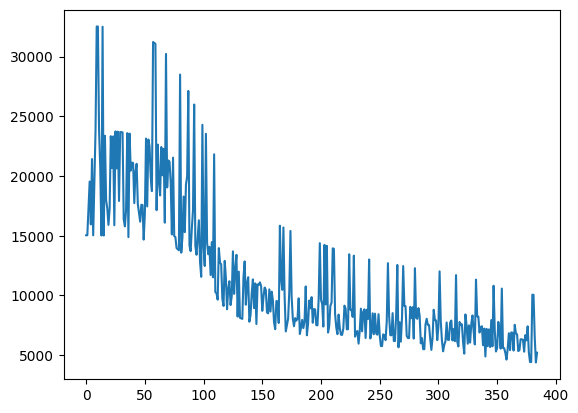

In [16]:
import seaborn as sns
import numpy as np

sns.lineplot(torch.tensor(np.array(hist)).view(-1))
torch.tensor(np.array(hist)).mean()

# Summary

Working training now for autoencoder

### Save Encoder Weights

In [56]:
import datetime

s = f'Encoder_weights_{datetime.datetime.now().strftime("%d%m%y%H%M%S")}.pt'
s

'Encoder_weights_211024184155.pt'

In [31]:
model = config['model']

In [57]:
enc = model.encoder
torch.save(enc.state_dict(), s)

# Trial